# Document representation and text classification

In [27]:
import sklearn.feature_extraction # Módulo de sklearn para extracción de características
import datasets # Biblioteca de manejo de conjuntos de datos para procesamiento de lenguaje natural
import sklearn.naive_bayes # Módulo de sklearn con métodos de Naïve Bayes
import sklearn.metrics # Módulo de sklearn de métricas de desempeño
import sklearn.pipeline # Módulo de sklearn para el desarrollo de flujos de trabajo
import sklearn.model_selection # Módulo de sklearn para selección de modelos
import numpy as np # Biblioteca de manejo de datos vectoriales
import pandas as pd # Biblioteca de manejo de conjuntos de datos
import spacy.lang.es # Biblioteca de procesamiento de lenguaje natural
import matplotlib.pyplot as plt # Biblioteca de visualización

Cargamos el conjunto de datos del curso.

In [2]:
spanish_diagnostics = datasets.load_dataset('fvillena/spanish_diagnostics') # Cargamos las particiones de entrenamiento y prueba

Using custom data configuration default
Reusing dataset spanish_diagnostics (C:\Users\ville\.cache\huggingface\datasets\spanish_diagnostics\default\0.0.0\45c176cea64580ea9631f78c2867a657ede368597681e5337e9f1c976e4e84ff)


Cargamos una lista de stopwords desde la biblioteca Spacy.

In [28]:
stopwords = spacy.lang.es.stop_words.STOP_WORDS # La biblioteca Spacy tiene una lista de stopwords en español

## Representación de documentos

Para poder trabajar con datos de texto, estos deben ser representados de una manera que pueda ser interpretada por los algoritmos de minería de texto. Típicamente se desea llegar a una matriz que tenga tantas filas como documentos tenga nuestro corpus y tantas columnas como características fueron extraídas desde el texto.

Revisaremos 2 métodos de extracción de características:

* Bag-of-words: Este método extrae la frecuencia de aparición de cada una de las palabras del documento y representa un documento como un vector de tantas dimensiones como palabras tenga el vocabulario.

* Term frequency - inverse document frequency (TF-IDF): Este método extrae la frecuencia de aparición de cada una de las palabras y la multiplica por el inverso de la frecuencia de aparición de la palabra en todos los documentos. También se representa cada documento como un vector de tantas dimensiones como palabras tenga el vocabulario.

Instanciamos un extractor de características Bag-of-words.

In [29]:
count_vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    stop_words = stopwords, # Le pasamos la lista de stopwords para eliminarlas del vocabulario
    max_df = 0.05, # Eliminamos del vocabulario el 5% de palabras más frecuentes (stopwords específicas del corpus)
    min_df = 2 # Eliminamos del vocabulario las palabras que tienen una frecuencia menor a 2 (típicamente palabras malformadas)
)

Ajustamos el vectorizador sobre los textos del conjunto de prueba.

In [30]:
count_vectorizer.fit(spanish_diagnostics["train"]["text"])

CountVectorizer(max_df=0.05, min_df=2,
                stop_words={'actualmente', 'acuerdo', 'adelante', 'ademas',
                            'además', 'adrede', 'afirmó', 'agregó', 'ahi',
                            'ahora', 'ahí', 'al', 'algo', 'alguna', 'algunas',
                            'alguno', 'algunos', 'algún', 'alli', 'allí',
                            'alrededor', 'ambos', 'ampleamos', 'antano',
                            'antaño', 'ante', 'anterior', 'antes', 'apenas',
                            'aproximadamente', ...})

Exploraremos cómo está representando nuestros documentos este vectorizador.

Este es un texto de ejemplo del corpus.

In [6]:
spanish_diagnostics["train"]["text"][69983]

'- CARIES DENTINARIA PROFUNDA/  - Fundamento Clínico APS: caries profunda en relacion de la pieza dental 4.5 Caries de la dentina'

In [32]:
def get_word_scores(text,vectorizer):
    """A partir de un texto y un vectorizador retorna los puntajes asignados a cada palabra del texto"""
    feature_names = list({k: v for k, v in sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])}.keys()) # Vocabulario
    doc = vectorizer.transform([text]) # Vectorizamos el texto de entrada
    idxs = np.argwhere(doc)[:,1] # Extraemos los índices donde sí hay palabras representadas
    words = [feature_names[i] for i in idxs] # Extraemos las palabras asociadas a los índices extraídos
    scores = np.array(doc.todense())[0][idxs] # Extraemos los puntajes asociadas a los índices extraídos
    return list(reversed(sorted(zip(words,scores),key=lambda tup: tup[1]))) # Retornamos una lista de palabras y puntajes

Vemos que nuestro vectorizador le dio más peso a la palabra caries de nuestro documento porque es la palabra más frecuente y a a un grupo de palabras les asignó el mismo puntaje 1 porque cada una aprece 1 vez.

In [8]:
get_word_scores(spanish_diagnostics["train"]["text"][69983],count_vectorizer)

[('caries', 3),
 ('profunda', 2),
 ('relacion', 1),
 ('fundamento', 1),
 ('dentinaria', 1),
 ('dentina', 1),
 ('dental', 1)]

Ajustamos un vectorizador que utiliza TF-IDF y lo ajustamos.

In [9]:
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    stop_words = stopwords,
    max_df = 0.05,
    min_df = 2
)
tfidf_vectorizer.fit(spanish_diagnostics["train"]["text"])

TfidfVectorizer(max_df=0.05, min_df=2,
                stop_words={'actualmente', 'acuerdo', 'adelante', 'ademas',
                            'además', 'adrede', 'afirmó', 'agregó', 'ahi',
                            'ahora', 'ahí', 'al', 'algo', 'alguna', 'algunas',
                            'alguno', 'algunos', 'algún', 'alli', 'allí',
                            'alrededor', 'ambos', 'ampleamos', 'antano',
                            'antaño', 'ante', 'anterior', 'antes', 'apenas',
                            'aproximadamente', ...})

Podemos observar que caries sigue siendo la palabra con el mayor puntaje. Pero vemos que todas las palabras tienen un puntaje distinto, en donde destacamos que la palabra fundamento tiene el menor puntaje. Intuitivamente podemos darnos cuenta que esta representación es mejor porque la palabra fundamento no nos aporta mucha información en el documento.

In [33]:
get_word_scores(spanish_diagnostics["train"]["text"][69983],tfidf_vectorizer)

[('caries', 0.5841232685802328),
 ('profunda', 0.5052614123771014),
 ('dentina', 0.36362077674894117),
 ('relacion', 0.3005437092091348),
 ('dentinaria', 0.27911008594273823),
 ('dental', 0.25831112531154554),
 ('fundamento', 0.19062330472026245)]

Vectorizamos los textos de nuestros conjuntos de entrenamiento y prueba. con el método CountVectorizer.transform()

In [34]:
text_vectorized_train = count_vectorizer.transform(spanish_diagnostics["train"]["text"])
text_vectorized_test = count_vectorizer.transform(spanish_diagnostics["test"]["text"])
feature_names = list({k: v for k, v in sorted(count_vectorizer.vocabulary_.items(), key=lambda item: item[1])}.keys())

La forma de nuestra matriz es de (cantidad de documentos en el conjunto, tamaño del vocabulario)

In [36]:
text_vectorized_train.shape

(70000, 13549)

In [37]:
text_vectorized_test.shape

(30000, 13549)

## Naïve Bayes

Naïve bayes es un método de clasificación que aplica el teorema de bayes a la asignación entre las características y las clases. Este método entrena un modelo de probabilidad condicional en donde le asigna probabilidades de pertenecer a una clase a cada una de las características del conjunto.

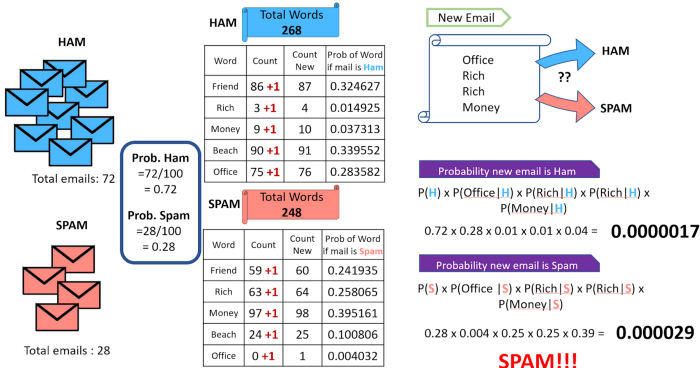

Instanciamos y ajustamos el clasificador basado en Naïve Bayes

In [38]:
classifier = sklearn.naive_bayes.MultinomialNB()
classifier.fit(text_vectorized_train,spanish_diagnostics["train"]["label"])

MultinomialNB()

Extraemos las probabilidades condicionales de cada una de las palabras del vocabulario.

In [16]:
log_probability = pd.DataFrame(classifier.feature_log_prob_.T, index = feature_names)

Se observa que la palabra caries es más probable que pertenezca a la clase dental que a la no-dental

In [17]:
log_probability.sort_values(1,ascending=False)

,0,1
caries,-6.562705,-4.096030
desdentado,-9.957213,-4.243286
periodontitis,-9.861903,-4.328295
pulpitis,-9.694849,-4.495746
diente,-7.568450,-4.501783
...,...,...
microalbuminuria,-9.774892,-12.247651
microadenoma,-10.873504,-12.247651
micro,-10.180357,-12.247651
micoticas,-11.161186,-12.247651


Se observa que la palabra hta es más probable que pertenezca a la clase no-dental que a la dental

In [40]:
log_probability.sort_values(0,ascending=False)

,0,1
hta,-4.877052,-6.969536
fundamento,-5.000682,-4.608971
derecho,-5.017716,-6.671702
dolor,-5.114602,-5.443037
derecha,-5.128899,-5.961653
...,...,...
paramandibular,-12.259798,-11.149039
erpcionado,-12.259798,-11.149039
paralelo,-12.259798,-10.638213
cronnica,-12.259798,-11.149039


Probamos nuestro clasificador sobre el subconjunto de prueba y verificamos su rendimiento.

In [41]:
print(sklearn.metrics.classification_report(
    spanish_diagnostics["test"]["label"],
    classifier.predict(text_vectorized_test)
))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     15034
           1       0.93      0.96      0.94     14966

    accuracy                           0.94     30000
   macro avg       0.94      0.94      0.94     30000
weighted avg       0.94      0.94      0.94     30000



Generamos unos ejemplos adicionales para verificar cómo se comporta nuestro clasificador y observamos que la frase cáncer de colon la clasifica como no-dental y la frase caries dentinaria como dental.

In [20]:
classifier.predict_proba(
    count_vectorizer.transform(["cáncer de colon","caries dentinaria"])
)

array([[0.97514586, 0.02485414],
       [0.00376949, 0.99623051]])

# Comparación

Unas de las decisiones que hay que tomar es qué método de vectorización se utilizará y además otro atributo que se puede agregar es si voy a tomar sólo palabras aisladas o voy a a agrupar palabras para aumentar mis características. Verifiquemos cómo se comporta el rendimiento del clasificador al modular estas variables.

In [45]:
def get_cv_performance(features, label, vectorizer):
    """ Dadas las características y etiquetas de un conjunto de datos, un vectorizador y un clasificador, se
    entrena un modelo de Naïve Bayes y se retorna su cross-validated AUC """
    pipe = sklearn.pipeline.Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', sklearn.naive_bayes.MultinomialNB())
    ])
    scores = sklearn.model_selection.cross_val_score(
        estimator = pipe,
        X = features,
        y = label,
        scoring = "roc_auc"
    )
    return scores

Bag-of-words sólo utilizando unigramas.

In [46]:
count_vectorizer_unigram_naive_bayes = get_cv_performance(
    spanish_diagnostics["train"]["text"],
    spanish_diagnostics["train"]["label"],
    sklearn.feature_extraction.text.CountVectorizer(ngram_range=(1,1)),
)

Bag-of-words utilizando unigramas y bigramas.

In [47]:
count_vectorizer_bigram_naive_bayes = get_cv_performance(
    spanish_diagnostics["train"]["text"],
    spanish_diagnostics["train"]["label"],
    sklearn.feature_extraction.text.CountVectorizer(ngram_range=(1,2)),
)

TF-IDF sólo utilizando unigramas.

In [48]:
tfidf_vectorizer_unigram_naive_bayes = get_cv_performance(
    spanish_diagnostics["train"]["text"],
    spanish_diagnostics["train"]["label"],
    sklearn.feature_extraction.text.TfidfVectorizer(ngram_range=(1,1)),
)

TF-IDF sólo utilizando unigramas y bigramas.

In [49]:
tfidf_vectorizer_bigram_naive_bayes = get_cv_performance(
    spanish_diagnostics["train"]["text"],
    spanish_diagnostics["train"]["label"],
    sklearn.feature_extraction.text.TfidfVectorizer(ngram_range=(1,2)),
)

Se concluye que las variables si tienen incidencia sobre el resultado y la utilización de TF-IDF con unigramas y bigramas tiene el mejor rendimiento.

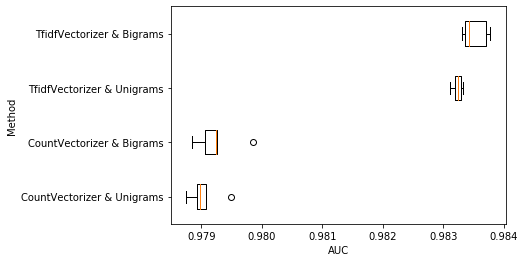

In [26]:
plt.boxplot(
    [count_vectorizer_unigram_naive_bayes, count_vectorizer_bigram_naive_bayes, tfidf_vectorizer_unigram_naive_bayes, tfidf_vectorizer_bigram_naive_bayes],
    labels = ["CountVectorizer & Unigrams", "CountVectorizer & Bigrams", "TfidfVectorizer & Unigrams", "TfidfVectorizer & Bigrams"],
    vert = False
)
plt.ylabel("Method")
plt.xlabel("AUC")
plt.show()